In [1]:
import os
import csv
import pandas as pd
import numpy as np

import re
from stop_words import get_stop_words
import unicodedata
from num2words import num2words
import nltk
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import Counter
import collections

from nltk import ngrams
from nltk.probability import FreqDist

**1. Carga de Datos**
<br> Para la práctica nos vamos a quedar solamente con un subset de 10000 reviews, ya que quedarnos con todos haría que el proceso fuese más lento, lo cuál no interesa en el aprendizaje.

In [2]:
dataset_path = '../dataset'

videogames_json = 'reviews_Video_Games_5.json.gz'
pet_json = 'reviews_Pet_Supplies_5.json.gz'

videogames = pd.read_json(os.path.join(dataset_path, videogames_json), lines=True, compression='gzip')
pet = pd.read_json(os.path.join(dataset_path, pet_json), lines=True, compression='gzip')


review_videogames=videogames.dropna(subset=['reviewText', 'overall'])[['reviewText', 'overall']]
review_pet=pet.dropna(subset=['reviewText','overall'])[['reviewText', 'overall']]

# Nos quedamos solo con la columna del texto de la reseña para esta primera fase exploratoria de texto.
df_videogames=videogames.dropna(subset=['reviewText'])[['reviewText']]
df_pet=pet.dropna(subset=['reviewText'])[['reviewText']]

# Nos quedamos con 10000 reviews
df_videogames = df_videogames[0:9999]
df_pet = df_pet[0:9999]

review_videogames = review_videogames[0:9999]
review_pet = review_pet[0:9999]

In [3]:
df_pet[1:5]

,reviewText
1,There are usually one or more of my cats watch...
2,I bought the triliogy and have tested out all ...
3,My female kitty could care less about these vi...
4,"If I had gotten just volume two, I would have ..."


**2. Limpieza de datos**

In [4]:
def text_cleaning(text, remove_stopwords = True):
   
    # Todo en minúsculas
    text = text.lower()
    
    # Eliminación de caracteres no deseados y acentos 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Eliminación de números
    text = re.sub(r'[0-9]+', ' ', text)
    
    # Conversión de números a texto
    #text = ' '.join([word if not word.isdigit() else num2words(word, ordinal=False) for word in text.split(' ')])
    
    # Eliminación de stopwords
    if remove_stopwords:
        sw_list = get_stop_words('en')
        text = ' '.join([word for word in text.split() if word not in sw_list])
    
    # Lematización
    lemmatizer = WordNetLemmatizer()
    
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
        
    
    return text

In [5]:
clean_pet = []
for text in df_pet.reviewText:
    clean_pet.append(text_cleaning(text))

In [6]:
original_pet = []
for text2 in df_pet.reviewText:
    original_pet.append(text2)

In [7]:
clean_pet[0:2]

['purchased trilogy hoping two cat age interested yr old cat fascinated minute picture came got bored year old watched minute walked away possible wonderful courtyard full greenery tree one neighbor bird feeder enough going outside prefer real life versus taped version will likely pas friend cat much wildlife watch mine',
 'usually one cat watching tv staying trouble dvd playing seem like mouse bird maybe go little le stir crazy inside time']

In [8]:
original_pet[0:2]

["I purchased the Trilogy with hoping my two cats, age 3 and 5 would be interested.  The 3 yr old cat was fascinated for about 15 minutes but when the same pictures came on, she got bored.  The 5 year old watched for about a few minutes but then walked away. It is possible that because we have a wonderful courtyard full of greenery and trees and one of my neighbors has a bird feeder, that there is enough going on outside that they prefer real life versus a taped version.  I will more than likely pass this on to a friend who has cats that don't have as much wildlife to watch as mine do.",
 'There are usually one or more of my cats watching TV and staying out of trouble when this DVD is playing.  They seem to like the mice and birds the most and maybe go a little less stir crazy being inside all the time.']

In [9]:
clean_videogames = []
for text in df_videogames.reviewText:
    clean_videogames.append(text_cleaning(text))

**3. Análisis exploratorio: visualización**

**3.1. Word Cloud**

In [202]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=110, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [203]:
def img_wc_plot(text, mask):
    wordcloud = WordCloud(max_font_size=50, max_words=110, background_color="white", mask = mask).generate(' '.join(text))
    plt.figure(figsize=(20,12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Me he tomado la licencia de probar las nubes de palabras con formas, que son más atractivas visualmente.

In [204]:
from PIL import Image
dog_mask = np.array(Image.open(os.path.join(dataset_path, "dog_shape.jpg")))
pacman_mask = np.array(Image.open(os.path.join(dataset_path, "pacman.jpg")))

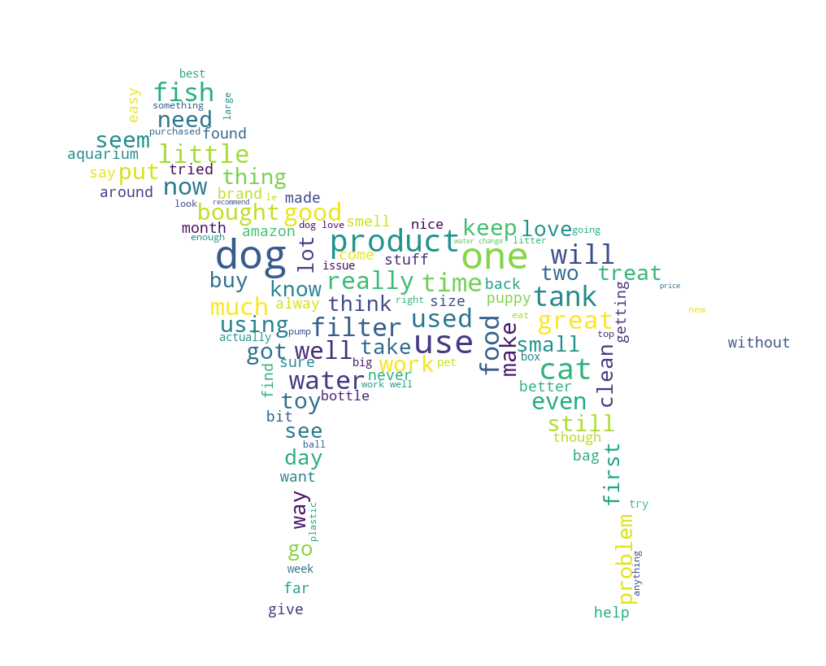

In [205]:
img_wc_plot(clean_pet, dog_mask)

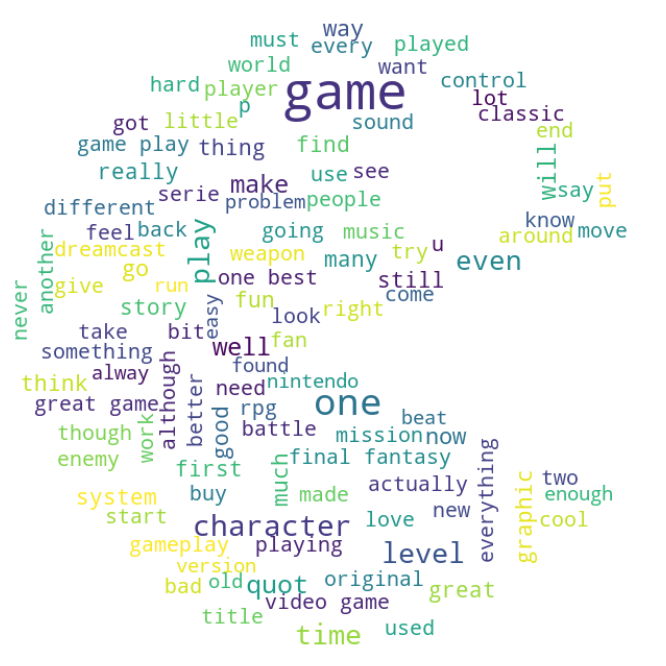

In [206]:
img_wc_plot(clean_videogames, pacman_mask)

**3.2. Cantidad de Reviews por número de estrellas**

<AxesSubplot:>

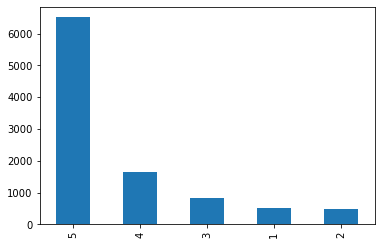

In [207]:
review_pet['overall'].value_counts().plot(kind='bar')

<AxesSubplot:>

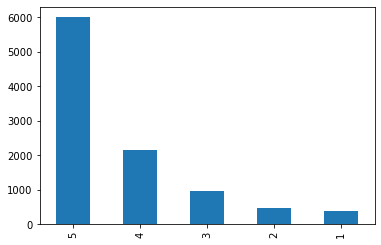

In [208]:
review_videogames['overall'].value_counts().plot(kind='bar')

Vemos que en ambos casos están muy desbalanceados, habiendo una cantidad muy superior de valoraciones de 5 estrellas al resto de las posibles puntuaciones. 
Por ello, a la hora de dicotomizar la variable tomaremos el 3, 2 y 1 como reviews negativa y el 4 y el 5 como reviews positivas.

He probado a hacer el plot con todas las reviews por si pudiera tratarse de un sesgo al haber cogido solo 10000 entradas, no obstante los gráficos son prácticamente iguales, así que seguiré utilizando ese número de registros.

**3.3. Frecuencias de palabras**

In [209]:
def flat_word_convert(listname, text):
    for sublist in text:
        for item in sublist.split():
            listname.append(item)

In [210]:
flat_words_pet = []
flat_word_convert(flat_words_pet, clean_pet)

In [211]:
flat_words_videogames = []
flat_word_convert(flat_words_videogames, clean_videogames)

Creamos una lista con todas las palabras y otra con las 20 palabras más comunes para realizar un gráfico legible para ambos conjuntos de datos.

In [212]:
def getList(dict):
    return dict.keys()

count_pet = dict(collections.Counter(flat_words_pet))
count_videogames = dict(collections.Counter(flat_words_videogames))

common_pet = dict(collections.Counter(flat_words_pet).most_common(20))
common_videogames = dict(collections.Counter(flat_words_videogames).most_common(20))

words_pet = list(getList(count_pet))
freq_pet = []
for word in words_pet:
    freq_pet.append(count_pet[word])

common_words_pet = list(getList(common_pet))
common_freq_pet = []
for word in common_pet:
    common_freq_pet.append(count_pet[word])
    

words_videogames = list(getList(count_videogames))
freq_videogames = []
for word in words_videogames:
    freq_videogames.append(count_videogames[word])

common_words_videogames = list(getList(common_videogames))
common_freq_videogames = []
for word in common_videogames:
    common_freq_videogames.append(count_videogames[word])

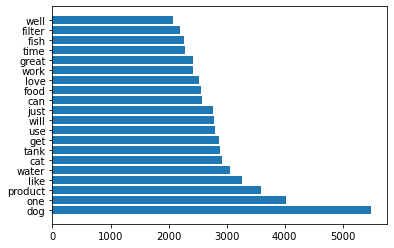

In [213]:
plt.barh(common_words_pet, common_freq_pet)
plt.show()

Vemos que aparecen palabras como "dog" o "cat", "fish", etc. Palabras que tienen que ver con el tema. En la primera prueba dos de las palabras comunes eran dog y dogs, por ello, incluí la lematización en la limpieza de los datos, lo que hizo que "dog" fuese la palabra más común.

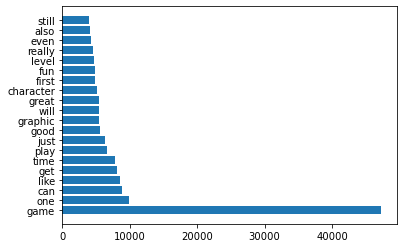

In [214]:
plt.barh(common_words_videogames, common_freq_videogames)
plt.show()

En este caso, podemos ver cómo hay una palabra que sobresale mucho sobre las demás: "game", lo cuál concuerda con el tema. Como en el caso anterior, aparecían palabras que podríamos considerar iguales como "play" y "played".

**3.4. Frecuencia de N-Gramas**

Para terminar con la exploración visual, vamos a visualizar la frecuencia de los 10 bigramas y trigramas más comunes de cada conjunto de datos

In [215]:
def most_common_ngram(words, n, topn):
    ng = list(ngrams(words, n))
    ng_freq = FreqDist(ng)
    ng_common = dict(collections.Counter(ng_freq).most_common(topn))
              
    ng_list_common = list(getList(ng_common))
    
    ng_list = []
    for word in ng_list_common:
        ng_list.append(ng_common[word])
    
    final_list = []
    for item in ng_list_common:
        final_list.append("".join(str(item)))
        
    return final_list, ng_list

def plot_ngram(words, freq, title):
    plt.barh(words, freq)
    plt.title(title)
    plt.show()

In [216]:
bigram_pet, bigram_pet_freq = most_common_ngram(flat_words_pet, 2, 10)
trigram_pet, trigram_pet_freq = most_common_ngram(flat_words_pet, 3, 10)

bigram_videogames, bigram_videogames_freq = most_common_ngram(flat_words_videogames, 2, 10)
trigram_videogames, trigram_videogames_freq = most_common_ngram(flat_words_videogames, 3, 10)

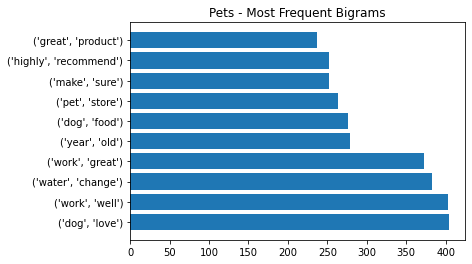

In [217]:
plot_ngram(bigram_pet, bigram_pet_freq, "Pets - Most Frequent Bigrams")

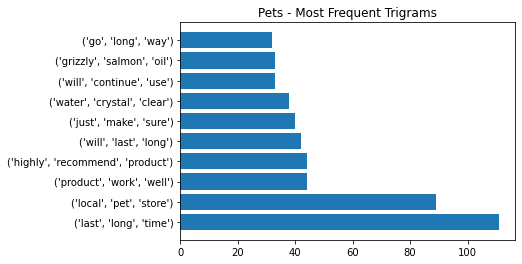

In [218]:
plot_ngram(trigram_pet, trigram_pet_freq, "Pets - Most Frequent Trigrams")

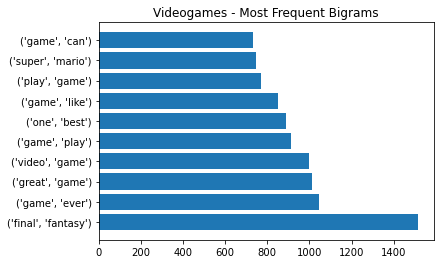

In [219]:
plot_ngram(bigram_videogames, bigram_videogames_freq, "Videogames - Most Frequent Bigrams")

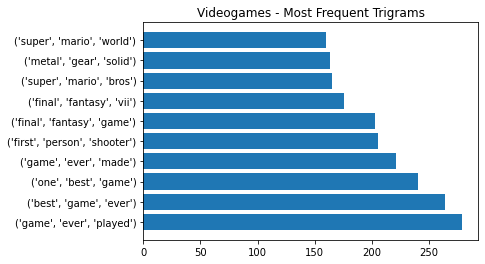

In [220]:
plot_ngram(trigram_videogames, trigram_videogames_freq, "Videogames - Most Frequent Trigrams")

Se pueden ver como entre los bigramas y trigramas más frecuentes se encuentran bastantes que hacen referencia a los números, lo que no nos da demasiado información, por ello, he decidido eliminar los números en vez de transformarlos a texto para las visualizaciones.

Al eliminar los números, los bigramas y trigamas restantes son mucho más significativos y mucho más temáticos.

Muchos ngramas son positivos y ninguno es negativo ("great, product"; "will, continue", "use"; "best", "game", "ever"; etc.), lo que concuerda con la gran cantidad de reviews positivas frente a las negativas.
 
En el caso de los productos para mascota, podemos ver con las frecuencias de palabras y ngramas, por ejemplo, que las reviews que mencionan a una mascota canina son muy superiores a las que mencionan otros tipos de mascota.

En el caso de los videojuegos, vemos que se hace mención a juegos clásicos como super mario, metal gear solid y final fantasy en las reviews, se pueden tomar como referentes y puntos de comparación para otros juegos.